In [1]:
import sys
sys.path.append('/home/s94zalek_hpc/shape_matching')

import torch

sys.path.append('/home/s94zalek_hpc/shape_matching/pyFM_fork')
import pyFM

import numpy as np

from pyFM.mesh import TriMesh
from pyFM.functional import FunctionalMapping

import trimesh

scene = trimesh.Scene()

In [2]:
import my_code.diffusion_training.data_loading as data_loading

test_dataset = data_loading.get_val_dataset(
    'FAUST_r', 'train', 200
    )[1]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading base dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:15<00:00,  5.13it/s]


In [3]:
data_10 = test_dataset[15]

In [4]:
from pyFM.mesh import TriMesh

mesh1 = TriMesh(
    data_10['first']['verts'],
    data_10['first']['faces'],
    center=True, area_normalize=True
    ).process(k=150, intrinsic=True)

mesh2 = TriMesh(
    data_10['second']['verts'],
    data_10['second']['faces'],
    center=True, area_normalize=True
    ).process(k=150, intrinsic=True)

In [5]:
mesh1_geo = mesh1.get_geodesic()
mesh2_geo = mesh2.get_geodesic()

# Visualize vertex 0

In [ ]:
import trimesh.visual


mesh1_trimesh = trimesh.Trimesh(
    vertices=mesh1.vertices,
    faces=mesh1.faces
    )
cmap = trimesh.visual.color.interpolate(mesh1_trimesh.vertices[:, 1], 'jet')
cmap[0] = np.zeros_like(cmap[0])

mesh1_trimesh.visual.vertex_colors = cmap

mesh2_trimesh = trimesh.Trimesh(
    vertices=mesh2.vertices + np.array([1, 0, 0]),
    faces=mesh2.faces
    )

scene.geometry.clear()

scene.add_geometry(mesh1_trimesh)
scene.add_geometry(mesh2_trimesh)

scene.show()

In [24]:
# get 20 closest vertices on mesh1 using geodesic distance

anchor_vertex = 0
n_closest_vertices = 50

# get 20 closest vertices on mesh1 using geodesic distance
geo_dist_anchor = mesh2_geo[anchor_vertex]
closest_vertices = np.argsort(geo_dist_anchor)[1:n_closest_vertices + 1]

distances_to_anchor = geo_dist_anchor[closest_vertices]
print(f'Distance to anchor, sum: {distances_to_anchor.sum():.2f}, mean: {distances_to_anchor.mean():.3f}')

print('Closest', closest_vertices)

# round to 3 decimal places
print('Distances', np.round(distances_to_anchor, 3))

Distance to anchor, sum: 1.54, mean: 0.031
Closest [  67 1330   70    1   73   15 2380 1328  117  153   27   69   68  135
  108   14  154 1805   13  150 1329  114   37  152   45 2381  120 1807
   72 1806  138  123 2558   75   44  101   74   46  121 2598  118 2564
   98 2596 4299 1800 2613 1799  107 2638]
Distances [0.009 0.009 0.009 0.01  0.012 0.013 0.016 0.018 0.018 0.019 0.02  0.02
 0.021 0.023 0.023 0.025 0.025 0.026 0.026 0.027 0.027 0.03  0.031 0.032
 0.032 0.032 0.033 0.034 0.034 0.035 0.035 0.036 0.037 0.038 0.039 0.039
 0.039 0.04  0.041 0.042 0.042 0.043 0.044 0.045 0.046 0.047 0.047 0.048
 0.048 0.048]


# Visuzalize anchor vertex and its neighbors

In [ ]:
import trimesh.visual


mesh1_trimesh = trimesh.Trimesh(
    vertices=mesh1.vertices,
    faces=mesh1.faces
    )

mesh2_trimesh = trimesh.Trimesh(
    vertices=mesh2.vertices + np.array([1, 0, 0]),
    faces=mesh2.faces
    )

cmap = trimesh.visual.color.interpolate(mesh2_trimesh.vertices[:, 1], 'jet')
cmap[anchor_vertex] = np.ones_like(cmap[anchor_vertex]) * 255

for i in closest_vertices:
    cmap[i] = np.zeros_like(cmap[i])

mesh2_trimesh.visual.vertex_colors = cmap

scene.geometry.clear()

scene.add_geometry(mesh1_trimesh)
scene.add_geometry(mesh2_trimesh)

scene.show()

In [36]:
import utils.fmap_util as fmap_util

fmap_dim = 16

C_gt_xy = data_10['second']['C_gt_xy'][0][:fmap_dim, :fmap_dim]
data_x = data_10['first']
data_y = data_10['second']

p2p_gt = fmap_util.fmap2pointmap(
    C12=C_gt_xy,
    evecs_x=data_x['evecs'][:, :fmap_dim],
    evecs_y=data_y['evecs'][:, :fmap_dim],
    )

In [35]:
anchor_to_mesh1 = p2p_gt[anchor_vertex]
closest_to_mesh1 = p2p_gt[closest_vertices]

distances_to_anchor_p2p = mesh1_geo[anchor_to_mesh1][closest_to_mesh1]

print(f'Distance to anchor, sum: {distances_to_anchor_p2p.sum():.2f}, mean: {distances_to_anchor_p2p.mean():.3f}, median: {np.median(distances_to_anchor_p2p):.3f}')
print('closest_to_mesh1', closest_to_mesh1)
print('distances', np.round(distances_to_anchor_p2p, 3))


Distance to anchor, sum: 10.10, mean: 0.202, median: 0.021
closest_to_mesh1 tensor([6800, 6766, 6766, 6800, 6766, 6800, 6766, 6766, 3399, 6766, 6765, 6800,
        3399, 6800, 6766, 6800, 6766, 6766, 6765, 6765, 6766, 3399, 6766, 6766,
        6734, 6800, 6765, 3399, 6765, 6766, 6766, 6765, 3399, 6765, 6734, 6766,
        6765, 6734, 6765, 6766, 6766, 6766, 6765, 6766, 3401, 6765, 3401, 3399,
        6765, 6766])
distances [0.    0.021 0.021 0.    0.021 0.    0.021 0.021 1.181 0.021 0.016 0.
 1.181 0.    0.021 0.    0.021 0.021 0.016 0.016 0.021 1.181 0.021 0.021
 0.015 0.    0.016 1.181 0.016 0.021 0.021 0.016 1.181 0.016 0.015 0.021
 0.016 0.015 0.016 0.021 0.021 0.021 0.016 0.021 1.182 0.016 1.182 1.181
 0.016 0.021]


# How does changing the sign of eigenfunction change the functional map?

random_sign 8
Nonzero elements 70 / 256


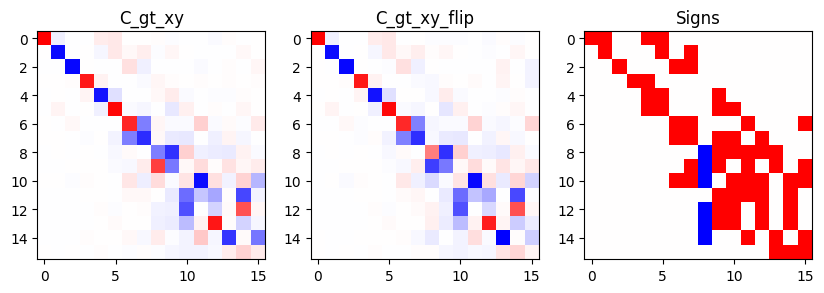

In [25]:
import matplotlib.pyplot as plt

fmap_dim = 16

C_gt_xy = data_10['second']['C_gt_xy'][0][:fmap_dim, :fmap_dim]
data_x = data_10['first']
data_y = data_10['second']


evecs_x_flip = data_x['evecs'][:, :fmap_dim].clone()

# change random sign to -1
random_sign = torch.randint(0, fmap_dim, (1,)).item()
print('random_sign', random_sign)
evecs_x_flip[:, random_sign] *= -1

C_gt_xy_flip = torch.linalg.lstsq(
    data_y['evecs'][:, :fmap_dim][data_y['corr']],
    evecs_x_flip[data_x['corr']]
    ).solution

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(C_gt_xy, cmap='bwr', vmin=-1, vmax=1)
axs[0].set_title('C_gt_xy')

axs[1].imshow(C_gt_xy_flip, cmap='bwr', vmin=-1, vmax=1)
axs[1].set_title('C_gt_xy_flip')

sign_change = torch.sign(C_gt_xy) * torch.sign(C_gt_xy_flip)
sign_change[C_gt_xy.abs() < 0.05] = 0

print(f'Nonzero elements {(C_gt_xy.abs() > 0.05).int().sum()} / {C_gt_xy.numel()}')

axs[2].imshow(sign_change, cmap='bwr', vmin=-1, vmax=1)
axs[2].set_title('Signs')

plt.show()


In [ ]:
total = 0

for side in range(1, 64):
    iter_per_side = 2**(int(side / 2))
    total += iter_per_side
    
    print(f'{side}) +{iter_per_side} ={total}')

# Full pipeline

In [6]:
import utils.fmap_util as fmap_util

def get_distance_to_anchor(Cxy, evecs_x, evecs_y, anchor_vertex_list, closest_vertices_list, mesh_geo):

    p2p_gt = fmap_util.fmap2pointmap(
        C12=Cxy,
        evecs_x=evecs_x,
        evecs_y=evecs_y,
        )

    distance_sum = 0
    for i in range(len(anchor_vertex_list)):
        anchor_vertex = anchor_vertex_list[i]
        closest_vertices = closest_vertices_list[i]

        anchor_to_mesh = p2p_gt[anchor_vertex]
        closest_to_mesh = p2p_gt[closest_vertices]

        distances_to_anchor_p2p = mesh_geo[anchor_to_mesh][closest_to_mesh]
        
        distance_sum += distances_to_anchor_p2p.sum()
        
    return distance_sum


In [22]:
anchor_vertex_list = list(range(0, 5000, 50))
n_closest_vertices = 50

print(f'Using {len(anchor_vertex_list)} anchor vertices and {n_closest_vertices} closest vertices')

closest_vertices_list = []

# get closest vertices on mesh2 using geodesic distance

min_distance_sum = 0
for i in range(len(anchor_vertex_list)):
    anchor_vertex = anchor_vertex_list[i]
    geo_dist_anchor = mesh2_geo[anchor_vertex]
    closest_vertices = np.argsort(geo_dist_anchor)[1:n_closest_vertices + 1]
    closest_vertices_list.append(closest_vertices)
    
    distances_to_anchor_gt = geo_dist_anchor[closest_vertices]
    min_distance_sum += distances_to_anchor_gt.sum()
    
print(f'Distance to anchor, sum: {min_distance_sum:.2f}')

Using 100 anchor vertices and 50 closest vertices
Distance to anchor, sum: 157.15


In [45]:
fmap_dim = 11

C_gt_xy = data_10['second']['C_gt_xy'][0][:fmap_dim, :fmap_dim]
data_x = data_10['first']
data_y = data_10['second']

print(get_distance_to_anchor(
    C_gt_xy, 
    data_x['evecs'][:, :fmap_dim],
    data_y['evecs'][:, :fmap_dim], 
    anchor_vertex_list, 
    closest_vertices_list, 
    mesh1_geo))

166.70989493992622


In [46]:
import itertools
from tqdm import tqdm

# start with absolute values
C_xy_init = C_gt_xy.abs().clone()

# assert torch.allclose(C_xy_init.reshape(-1).reshape(fmap_dim, fmap_dim), C_xy_init)
C_xy_init = C_xy_init.reshape(-1)

# count elements with abs > 0.05
n_nonzero = (C_xy_init > 0.1).int().sum()
indices_nonzero = torch.nonzero(C_xy_init > 0.1).squeeze()

print('n_nonzero', n_nonzero)

# create n_nonzero permutations of - signs
sign_combinations = list(itertools.product([-1, 1], repeat=n_nonzero))


print(len(sign_combinations))

# copy C_xy_init sign_combinations times and assign signs from sign_combinations to nonzero elements
C_xy_candidates = C_xy_init.repeat(len(sign_combinations), 1)
for i, signs in enumerate(sign_combinations):
    C_xy_candidates[i, indices_nonzero] *= torch.tensor(signs)
    
distances_list = []
lowest_distance = 1e9

iterator = tqdm(C_xy_candidates[:5000])
for C_xy in iterator:
    C_xy = C_xy.reshape(fmap_dim, fmap_dim)
    
    distance_curr = get_distance_to_anchor(
        C_xy, 
        data_x['evecs'][:, :fmap_dim],
        data_y['evecs'][:, :fmap_dim], 
        anchor_vertex_list, 
        closest_vertices_list, 
        mesh1_geo)
    
    if distance_curr < lowest_distance:
        lowest_distance = distance_curr
        iterator.set_description(f'Lowest distance: {lowest_distance:.2f}')
    
    distances_list.append(distance_curr)
    
# get index of the best candidate
best_idx = torch.tensor(distances_list).argmin()
print(best_idx)



n_nonzero tensor(19)
524288


Lowest distance: 123.72: 100%|█████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:09<00:00, 26.44it/s]

tensor(3427)


In [47]:
lowest_distance_indices = torch.tensor(distances_list).argsort()

In [48]:
print(distances_list[lowest_distance_indices[0]], distances_list[lowest_distance_indices[1]])

123.7171203980392 126.63723901256706


(-1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1)
(-1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, 1)


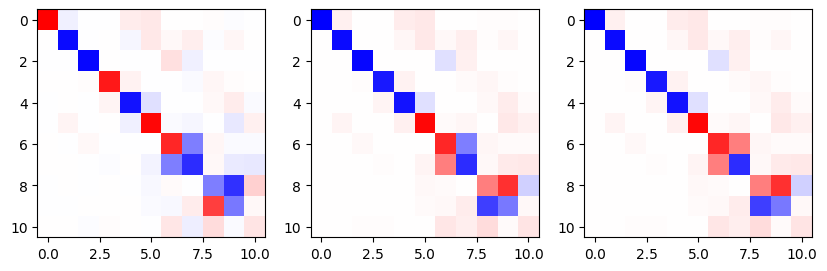

In [49]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(C_gt_xy, cmap='bwr', vmin=-1, vmax=1)

axs[1].imshow(C_xy_candidates[lowest_distance_indices[0]].reshape(fmap_dim, fmap_dim), cmap='bwr', vmin=-1, vmax=1)

axs[2].imshow(C_xy_candidates[lowest_distance_indices[1]].reshape(fmap_dim, fmap_dim), cmap='bwr', vmin=-1, vmax=1)


print(sign_combinations[lowest_distance_indices[0]])
print(sign_combinations[lowest_distance_indices[1]])
plt.show()
